#Importing all the Libraries and mounting google drive

In [1]:
!pip install emoji
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 6.7 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=56bb7369342c634a4ebf9864322d4ee9064275f2fc6d869286ac854a2ff4a956
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
sns.set_style("darkgrid")
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import re, string, nltk
import emoji, bz2
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.layers import Embedding
#from tensorflow.keras.preprocessing.sequence import pad_sequences   -------------------------> this ibrary is not working
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd

inputData = pd.read_csv("/content/drive/MyDrive/CS-688_Project/Twitter/twitterLarge.csv", encoding='ISO-8859-1', header=None)

In [7]:
inputData.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
data = inputData.drop([1,2,3,4], axis=1)
data.head()

,0,5
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [9]:
data[0] = data[0].apply(lambda x: 1 if x==0 else 2)
data

,0,5
0,1,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1,is upset that he can't update his Facebook by ...
2,1,@Kenichan I dived many times for the ball. Man...
3,1,my whole body feels itchy and like its on fire
4,1,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,2,Just woke up. Having no school is the best fee...
1599996,2,TheWDB.com - Very cool to hear old Walt interv...
1599997,2,Are you ready for your MoJo Makeover? Ask me f...
1599998,2,Happy 38th Birthday to my boo of alll time!!! ...


In [10]:
izuo1 = data.loc[data[0] == 1]
izuo2 = data.loc[data[0] == 2]

In [11]:
train1 = izuo1[:100000]
train2 = izuo2[:100000]

In [12]:
train1 = train1.reset_index(drop=True)
train2 = train2.reset_index(drop=True)

In [13]:
#concading tran1 and train2
frames = [train1, train2]
data = pd.concat(frames)

In [14]:
data = data.reset_index(drop=True)

In [15]:
data

,0,5
0,1,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1,is upset that he can't update his Facebook by ...
2,1,@Kenichan I dived many times for the ball. Man...
3,1,my whole body feels itchy and like its on fire
4,1,"@nationwideclass no, it's not behaving at all...."
...,...,...
199995,2,"@jvdouglas haha, no, the remark on maternity ..."
199996,2,@altitis and to you!
199997,2,Okie doke!! Time for me to escape for the Nort...
199998,2,"finished the lessons, hooray!"


In [16]:
data_shuffled = data.sample(frac=1).reset_index()
data_shuffled

,index,0,5
0,9342,1,Just woke up and as soon as I was about to sta...
1,158991,2,@xpb Everyone should watch that once - and the...
2,32886,1,@x_it Thanks. I'll post that information as a ...
3,33987,1,"Lost less than a pound, boo"
4,196001,2,I thought those we 2 pretty legit sentences fr...
...,...,...,...
199995,79090,1,@chrisviamusic a depressed girl who gives up o...
199996,117943,2,just asked my Dad why we never wash our van. h...
199997,191642,2,@Tomas57 NO! Foolish me rofl it's a great name...
199998,135479,2,Learning how to use this.


In [17]:
df = data_shuffled.iloc[:140000]
df1 = data_shuffled.iloc[140000:].reset_index()

In [18]:
df = df.drop(['index'], axis=1)
df.head()

,0,5
0,1,Just woke up and as soon as I was about to sta...
1,2,@xpb Everyone should watch that once - and the...
2,1,@x_it Thanks. I'll post that information as a ...
3,1,"Lost less than a pound, boo"
4,2,I thought those we 2 pretty legit sentences fr...


In [19]:
df1 = df1.drop(['level_0','index'], axis=1)
df1.head()

,0,5
0,1,So tired of my ears being stopped up!!!! I ca...
1,1,@youquit Maren's secret of the day: I really h...
2,1,Me &amp; C switched schedules I'm trying to g...
3,1,omg twitter blows. an hour late for updating??...
4,2,Was just about to start French assignment then...


In [20]:
df = df.rename(columns={5:4})

In [21]:
df = df.rename(columns={0:5})

In [22]:
df

,5,4
0,1,Just woke up and as soon as I was about to sta...
1,2,@xpb Everyone should watch that once - and the...
2,1,@x_it Thanks. I'll post that information as a ...
3,1,"Lost less than a pound, boo"
4,2,I thought those we 2 pretty legit sentences fr...
...,...,...
139995,2,So much fucking love tonight. I love my frien...
139996,1,ugh the smell of subway is making me sick today
139997,1,@suitestl wow that must have been some bad sin...
139998,1,no lets not talk about the football bastard l...


In [23]:
df1 = df1.rename(columns={5:4})

In [24]:
df1 = df1.rename(columns={0:5})

In [25]:
df1.head()

,5,4
0,1,So tired of my ears being stopped up!!!! I ca...
1,1,@youquit Maren's secret of the day: I really h...
2,1,Me &amp; C switched schedules I'm trying to g...
3,1,omg twitter blows. an hour late for updating??...
4,2,Was just about to start French assignment then...


In [26]:
df.shape

(140000, 2)

In [27]:
df1.shape

(60000, 2)

In [28]:
print(f"Trainning Data consists of {df.shape[0]} rows and {df.shape[1]} columns.")
print("\n")
print(f"Testing Data consists of {df1.shape[0]} rows and {df1.shape[1]} columns.")

Trainning Data consists of 140000 rows and 2 columns.


Testing Data consists of 60000 rows and 2 columns.


Text(0.5, 1.0, 'Countplot for Sentiment Labels')

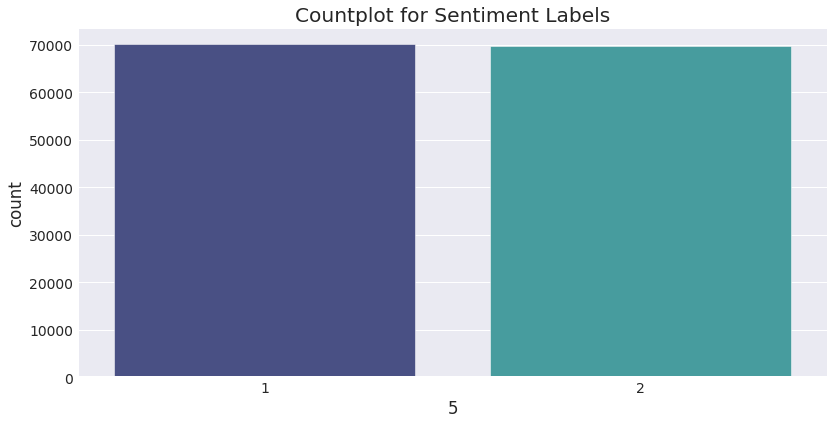

In [29]:
#sns.countplot(df[5],palette="mako")
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)
sns.countplot(df[5],palette="mako")
plt.title("Countplot for Sentiment Labels")

In [30]:
#using regex on both trainig and test data to remove numeric as well as any special character after converting it to lowercase
df[4]=df[4].str.lower()
df1[4]=df1[4].str.lower()
df[4] = [re.sub("[^a-z ]","", str(x)) for x in df[4]]
df1[4] = [re.sub("[^a-z ]","", str(x)) for x in df1[4]]
print(df[4][0])
print()
print(df1[4][0])

just woke up and as soon as i was about to start getting ready to party its raining 

so tired of my ears being stopped up  i cant hear anything and i feel like im talking in a tunnelugh 


In [31]:
#performing stemming and removing stopwords from training data
stemmer=SnowballStemmer("english")
stopWords = set(stopwords.words('english'))
df[4] = df[4].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() if word not in (stopWords)]))
df[4] = [word_tokenize(str(x)) for x in df[4]]
print(df[4][0])


['woke', 'soon', 'start', 'get', 'readi', 'parti', 'rain']


In [32]:
#performing stemming and removing stopwords from test data
df1[4] = df1[4].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() if word not in (stopWords)]))
df1[4] = [word_tokenize(str(x)) for x in df1[4]]
print(df1[4][0])

['tire', 'ear', 'stop', 'cant', 'hear', 'anyth', 'feel', 'like', 'im', 'talk', 'tunnelugh']


In [33]:

df1[4]=[' '.join(map(str, l)) for l in df1[4]]

In [34]:
df1.head()

,5,4
0,1,tire ear stop cant hear anyth feel like im tal...
1,1,youquit maren secret day realli hate music exc...
2,1,amp c switch schedul im tri get zzzs im wide a...
3,1,omg twitter blow hour late updat jeezmov lose
4,2,start french assign mum say go macca im ok


In [35]:
df[4]=[' '.join(map(str, l)) for l in df[4]]
df.head()

,5,4
0,1,woke soon start get readi parti rain
1,2,xpb everyon watch tri never watch fail know
2,1,xit thank ill post inform nd comment first cas...
3,1,lost less pound boo
4,2,thought pretti legit sentenc quotprejudicequot...


In [36]:
new_df = df[[4,5]]
new_df

,4,5
0,woke soon start get readi parti rain,1
1,xpb everyon watch tri never watch fail know,2
2,xit thank ill post inform nd comment first cas...,1
3,lost less pound boo,1
4,thought pretti legit sentenc quotprejudicequot...,2
...,...,...
139995,much fuck love tonight love friend lt im lucki,2
139996,ugh smell subway make sick today,1
139997,suitestl wow must bad sing im sorri suffer,1
139998,let talk footbal bastard lol im starv,1


In [37]:
new_testdf1=df1[[4,5]]
new_testdf1

,4,5
0,tire ear stop cant hear anyth feel like im tal...,1
1,youquit maren secret day realli hate music exc...,1
2,amp c switch schedul im tri get zzzs im wide a...,1
3,omg twitter blow hour late updat jeezmov lose,1
4,start french assign mum say go macca im ok,2
...,...,...
59995,chrisviamus depress girl give life find happi ...,1
59996,ask dad never wash van said cant polish turd lol,2
59997,toma foolish rofl great name alreadi rc follow...,2
59998,learn use,2


In [38]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df[4]),np.array(df[5]), test_size=0.25,random_state=42)
print(X_train.shape)
print(X_test.shape)

(105000,)
(35000,)


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf2 = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize)
X_train_tf2 = tfidf2.fit_transform(X_train)
X_test_tf2 = tfidf2.transform(X_test)

In [40]:
print(X_train_tf2)

  (0, 29580)	0.2768921447199214
  (0, 73655)	0.2240851102686167
  (0, 48131)	0.2536819512289793
  (0, 25615)	0.29075652010899933
  (0, 30805)	0.1655637228988786
  (0, 51366)	0.18422383499453976
  (0, 6031)	0.31620289291403936
  (0, 14985)	0.26367478686532764
  (0, 73273)	0.22091813178048728
  (0, 24404)	0.20012348770498484
  (0, 23885)	0.25062642409506036
  (0, 6248)	0.3289260793165593
  (0, 67633)	0.2544033448084213
  (0, 56485)	0.3597037545481938
  (0, 83013)	0.19848484191883045
  (1, 59734)	0.4213587668310391
  (1, 5861)	0.4867571933452039
  (1, 31011)	0.6260722706651008
  (1, 77133)	0.4399519703849168
  (2, 29545)	0.5186102372252105
  (2, 47591)	0.29471313842501046
  (2, 85819)	0.4580346190543021
  (2, 22367)	0.29169842094730825
  (2, 11481)	0.18632798710279247
  (2, 57397)	0.3552887565959189
  :	:
  (104996, 80183)	0.15333370720054132
  (104996, 87112)	0.1762722736460964
  (104996, 11481)	0.15088860745245095
  (104997, 28053)	0.4912856794881001
  (104997, 75966)	0.6086805745250877

In [41]:
rf = RandomForestClassifier()
rf.fit(X_train_tf2, y_train)

RandomForestClassifier()

In [42]:
from sklearn.metrics import roc_auc_score
y_pred = rf.predict(X_test_tf2)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_test, y_pred)
roc = roc_auc_score(y_test,y_pred)
print(f"Accuracy: {acc*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred)}")
print(report)

Accuracy: 75.12857142857143% and Roc Auc Score:0.7510327985446927
              precision    recall  f1-score   support

           1       0.74      0.78      0.76     17672
           2       0.76      0.73      0.74     17328

    accuracy                           0.75     35000
   macro avg       0.75      0.75      0.75     35000
weighted avg       0.75      0.75      0.75     35000



In [43]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import xgboost
import lightgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
xgb = XGBClassifier(eval_metric="mlogloss")
xgb.fit(X_train_tf2, y_train)

XGBClassifier(eval_metric='mlogloss')

In [46]:
y_pred2 = xgb.predict(X_test_tf2)
acc2 = accuracy_score(y_pred2, y_test)
report2 = classification_report(y_test, y_pred2)
roc2 = roc_auc_score(y_test,y_pred2)
print(f"Accuracy: {acc2*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred2)}")
print(report2)

Accuracy: 68.94857142857143% and Roc Auc Score:0.6910121498887912
              precision    recall  f1-score   support

           1       0.78      0.54      0.64     17672
           2       0.64      0.85      0.73     17328

    accuracy                           0.69     35000
   macro avg       0.71      0.69      0.68     35000
weighted avg       0.71      0.69      0.68     35000



In [47]:
lgb = LGBMClassifier()
lgb.fit(X_train_tf2, y_train)

LGBMClassifier()

In [48]:
y_pred_lgb = lgb.predict(X_test_tf2)
acc_lgb = accuracy_score(y_pred_lgb, y_test)
report_lgb = classification_report(y_test, y_pred_lgb)
roc_lgb = roc_auc_score(y_test,y_pred_lgb)
print(f"Accuracy: {acc_lgb*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred_lgb)}")
print(report_lgb)

Accuracy: 74.5142857142857% and Roc Auc Score:0.7457557500019855
              precision    recall  f1-score   support

           1       0.78      0.68      0.73     17672
           2       0.71      0.81      0.76     17328

    accuracy                           0.75     35000
   macro avg       0.75      0.75      0.74     35000
weighted avg       0.75      0.75      0.74     35000



In [49]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tf2, y_train)

MultinomialNB()

In [50]:
y_pred3 = nb.predict(X_test_tf2)
acc3 = accuracy_score(y_pred3, y_test)
report3 = classification_report(y_test, y_pred3)
roc3 = roc_auc_score(y_test,y_pred3)
print(f"Accuracy: {acc3*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred3)}")
print(report3)

Accuracy: 74.5142857142857% and Roc Auc Score:0.7445172303599771
              precision    recall  f1-score   support

           1       0.72      0.81      0.76     17672
           2       0.78      0.68      0.73     17328

    accuracy                           0.75     35000
   macro avg       0.75      0.74      0.74     35000
weighted avg       0.75      0.75      0.74     35000



In [51]:
gb = GradientBoostingClassifier()
gb.fit(X_train_tf2, y_train)

GradientBoostingClassifier()

In [52]:
y_pred4 = gb.predict(X_test_tf2)
acc4 = accuracy_score(y_pred4, y_test)
report4 = classification_report(y_test, y_pred4)
roc4 = roc_auc_score(y_test,y_pred4)
print(f"Accuracy: {acc4*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred4)}")
print(report4)

Accuracy: 69.20285714285714% and Roc Auc Score:0.6934959947281896
              precision    recall  f1-score   support

           1       0.78      0.54      0.64     17672
           2       0.64      0.84      0.73     17328

    accuracy                           0.69     35000
   macro avg       0.71      0.69      0.69     35000
weighted avg       0.71      0.69      0.69     35000



In [53]:
dt = DecisionTreeClassifier()
dt.fit(X_train_tf2, y_train)
y_pred5 = dt.predict(X_test_tf2)
acc5 = accuracy_score(y_pred5, y_test)
report5 = classification_report(y_test, y_pred5)
roc5 = roc_auc_score(y_test,y_pred5)
print(f"Accuracy: {acc5*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred5)}")
print(report5)

Accuracy: 69.14571428571429% and Roc Auc Score:0.6911714860971255
              precision    recall  f1-score   support

           1       0.68      0.72      0.70     17672
           2       0.70      0.66      0.68     17328

    accuracy                           0.69     35000
   macro avg       0.69      0.69      0.69     35000
weighted avg       0.69      0.69      0.69     35000



In [54]:
from sklearn.metrics import precision_score
ps = precision_score(y_test, y_pred)
ps_lgb = precision_score(y_test,y_pred_lgb)
ps2 = precision_score(y_test, y_pred2)
ps3 = precision_score(y_test, y_pred3)
ps4 = precision_score(y_test, y_pred4)
ps5 = precision_score(y_pred5,y_test)

In [55]:
accuracys = [acc,acc2,acc3,acc4,acc5,acc_lgb]
roc_scores = [roc, roc2, roc3, roc4,roc5, roc_lgb]
precision_scores = [ps,ps2,ps3,ps4,ps5,ps_lgb]
models = {"Random Forest":rf,"XGboost":xgb,"Naive Bayes":nb,"Gradient Boosting":gb,"Decision Tree":dt,"LGB Machine":lgb}

model_df = pd.DataFrame({"Models":models.keys(),"Accuracy":accuracys,"Precision Score":precision_scores,"Roc Scores": roc_scores}).sort_values("Roc Scores",ascending=False)

In [56]:
# Summary of Machine Learning Models Performance
model_df

,Models,Accuracy,Precision Score,Roc Scores
0,Random Forest,0.751286,0.742522,0.751033
5,LGB Machine,0.745143,0.784119,0.745756
2,Naive Bayes,0.745143,0.720876,0.744517
3,Gradient Boosting,0.692029,0.779272,0.693496
4,Decision Tree,0.691457,0.720235,0.691171
1,XGboost,0.689486,0.780462,0.691012


In [57]:
from sklearn.model_selection import train_test_split
X = new_df[4]
y = new_df[5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
display(X_train.shape)
display(X_test.shape)

(105000,)

(35000,)

In [58]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [59]:
# using tokenizer to transform text messages into training and testing set
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [60]:
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=64)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=64)

In [61]:
X_train_seq_padded[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,   253, 14598,  1171,  6527,  1079,
         265,   481,  1475,  4880,   154,    74,  2748,  1132,   531,
        2028], dtype=int32)

Bidirectional LSTM¶

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          5893248   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              132000    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,051,105
Trainable params: 6,051,105
Non-trainable params: 0
_________________________________________________________________


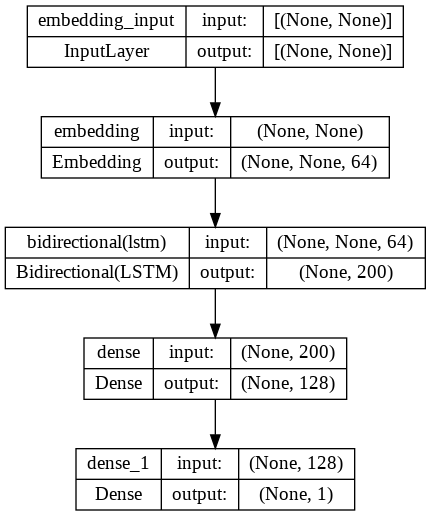

In [62]:
# construct model
BATCH_SIZE = 64

from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1,64))
model.add(Bidirectional(LSTM(100, dropout=0,recurrent_dropout=0)))
model.add(Dense(128, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("adam","binary_crossentropy",metrics=["accuracy"])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [63]:
# Used for preventing ovefitting
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=5,verbose=True)

In [64]:
history = model.fit(X_train_seq_padded, y_train,batch_size=BATCH_SIZE,epochs=15,
                    validation_data=(X_test_seq_padded, y_test),callbacks=[early_stop])

Epoch 1/15
1641/1641 [==============================] - 450s 271ms/step - loss: -13640.6650 - accuracy: 0.5003 - val_loss: -39031.1211 - val_accuracy: 0.5049
Epoch 2/15
1641/1641 [==============================] - 443s 270ms/step - loss: -84342.4531 - accuracy: 0.5003 - val_loss: -136100.6406 - val_accuracy: 0.5049
Epoch 3/15
1641/1641 [==============================] - 443s 270ms/step - loss: -204675.9062 - accuracy: 0.5003 - val_loss: -276258.1562 - val_accuracy: 0.5049
Epoch 4/15
1641/1641 [==============================] - 443s 270ms/step - loss: -365757.4375 - accuracy: 0.5003 - val_loss: -454796.1562 - val_accuracy: 0.5049
Epoch 5/15
1641/1641 [==============================] - 442s 269ms/step - loss: -563878.5625 - accuracy: 0.5003 - val_loss: -668890.2500 - val_accuracy: 0.5049
Epoch 6/15
1641/1641 [==============================] - 445s 271ms/step - loss: -798359.0625 - accuracy: 0.5003 - val_loss: -919299.4375 - val_accuracy: 0.5049
Epoch 7/15
1641/1641 [=====================

In [65]:
from sklearn.metrics import roc_auc_score
pred_train = model.predict(X_train_seq_padded)
pred_test = model.predict(X_test_seq_padded)
print('LSTM Recurrent Neural Network baseline: ' + str(roc_auc_score(y_train, pred_train)))
print('LSTM Recurrent Neural Network: ' + str(roc_auc_score(y_test, pred_test)))

1094/1094 [==============================] - 28s 26ms/step
LSTM Recurrent Neural Network baseline: 0.5
LSTM Recurrent Neural Network: 0.5


In [66]:
model.evaluate(X_test_seq_padded, y_test)

1094/1094 [==============================] - 29s 26ms/step - loss: -4730828.5000 - accuracy: 0.5049


[-4730828.5, 0.5049142837524414]

Text(0.5, 1.0, 'Training and Validation Accuracy')

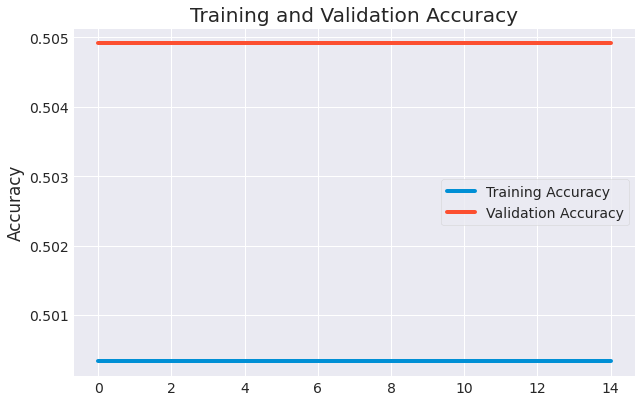

In [67]:
acc = history.history["accuracy"]
loss = history.history["loss"]

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(9,6))
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

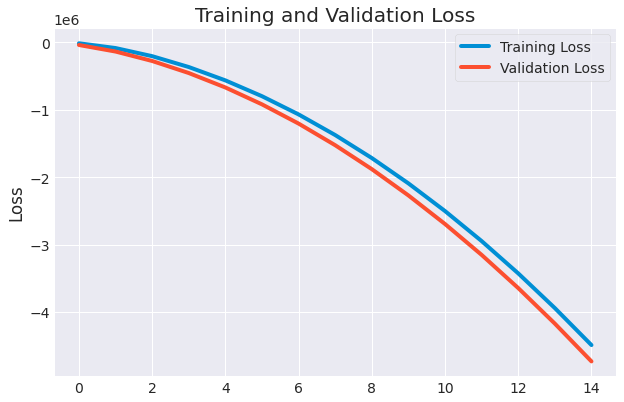

In [68]:
plt.figure(figsize=(9,6))
plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.ylabel("Loss")
plt.title("Training and Validation Loss")